#                                                    <span style = 'color: skyblue;'>  Tweet Spectrum : Unravelling the Sentiment Context of Twitter(X) </span>
###                                        Abdul Mannan Mohammad(Z1976622) Abdul Rabbani(Z1983919) Syed Nasir Ali Hussaini Syed(Z1944593) Muqeemuddin Mohammad(Z1983925)

## Importing neccessary libraries

In [1]:
#standard libraries
import os
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import re, string, unicodedata

#email library
import email
import email.policy

#parsing library
from bs4 import BeautifulSoup


#sklearn ml library
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#import nlp tookkit library
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('sentiwordnet')
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import sentiwordnet as swn
from nltk.stem import LancasterStemmer, WordNetLemmatizer


#import wordcloud
from wordcloud import WordCloud

import matplotlib.colors as mcolors

#import xgboost
import xgboost as xgb



#import plotting libs

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abdulrabbani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/abdulrabbani/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


## Loading the data into dataframe

In [33]:
#load data
df = pd.read_csv('/Users/abdulrabbani/Desktop/SEM-2/Information Storage and retrieval/Project/complete_work/complete_work/data.csv',
                 encoding = 'latin')
df.head(15)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


## Data Preprocessing step(1/3): Dropping unwanted columns

In [3]:
#lets drop unwanted columns
df = df.drop(['textID', 'text'], axis=1)
df.head()

#shuffling the data and also reset indexes
df = df.dropna()
df = df.sample(frac=1).reset_index(drop=True)
df.head()

#find classes
df['sentiment'].unique()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


## Data Preprocessing step(2/3) : Removing special characters which is of no use in predicting the sentiment

In [7]:
def remove_special_chars_from_dataframe(dataset):
    for i in range(len(dataset)):
        if isinstance(dataset.at[i, 'selected_text'], str):  # Check if it's a string
            dataset.at[i, 'selected_text'] = dataset.at[i, 'selected_text'].replace('!', '') \
                .replace('?', '').replace(',', '').replace('[', '') \
                .replace(']', '').replace('(', '').replace(')', '') \
                .replace('...', '').replace('>', '') \
                .replace('<', '').replace('\n', ' ') \
                .replace('-', '').replace('+', '') \
                .replace('#', '')
    return dataset

df = remove_special_chars_from_dataframe(df)
df.head()


,selected_text,sentiment
0,RATT ROCKED NASHVILLE TONITE..ONE THING SUCKED...,neutral
1,you`re hot,positive
2,y cute,positive
3,ts 35 now. ilycecily 3,positive
4,cool i wear black most of the time when i go out,neutral


## Data Preprocessing step(3/3) : Cleaning the text and Text Selection to give as an input to ML models

In [11]:
#clean text 
def text_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['selected_text'] = df['selected_text'].apply(lambda x:text_cleaning(x))
df.head()

,selected_text,sentiment
0,ratt rocked nashville toniteone thing sucked n...,neutral
1,youre hot,positive
2,y cute,positive
3,ts now ilycecily,positive
4,cool i wear black most of the time when i go out,neutral


# Exploratory Data Analysis

## Distribution of Sentiment Classes


<Axes: xlabel='sentiment', ylabel='count'>

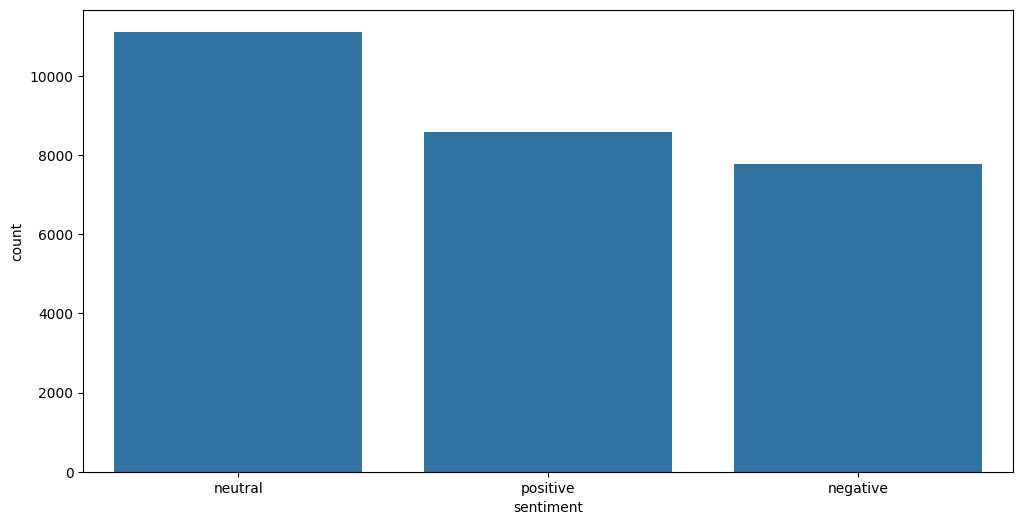

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df)

## Finding and extracting the lenghth of tweet text

In [14]:
#find length of tweet text
df['text_len'] = df['selected_text'].astype(str).apply(len)#find length of tweet text
df['text_len'] = df['selected_text'].astype(str).apply(len)

#extract length of tweet text for each sentiment
pos_df = df[df['sentiment']=='positive']
neg_df = df[df['sentiment']=='negative']
neutral_df = df[df['sentiment']=='neutral']

# Tweet Text length distribution(Positive)

/var/folders/4y/kdhr0h493ln2xtn2ftcd93km0000gn/T/ipykernel_11023/1465300622.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lens);


Text(0.5, 1.0, 'Positive Tweet Text length distribution')

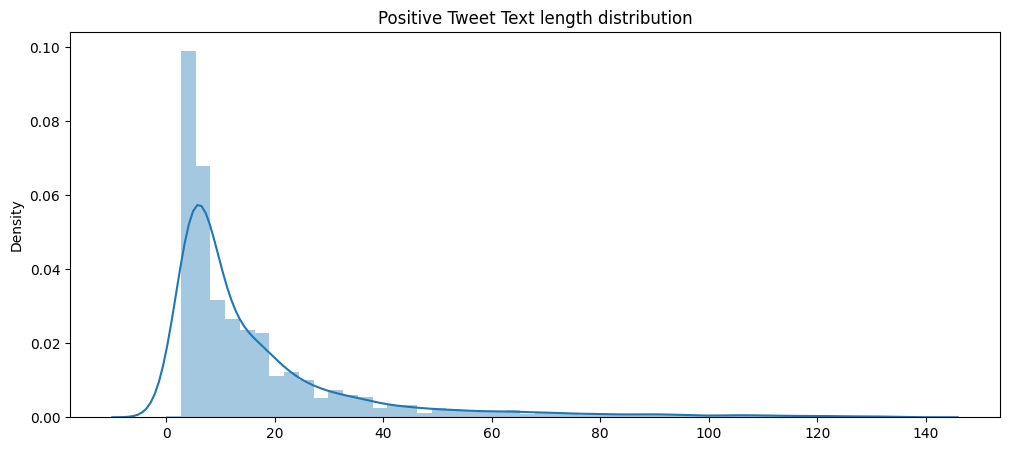

In [15]:
lens = [len(x) for x in pos_df.selected_text]
plt.figure(figsize=(12, 5));
sns.distplot(lens);
plt.title('Positive Tweet Text length distribution')

# Tweet Text length distribution(Negative)

/var/folders/4y/kdhr0h493ln2xtn2ftcd93km0000gn/T/ipykernel_1707/820776326.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lens);


Text(0.5, 1.0, 'Negative Tweet Text length distribution')

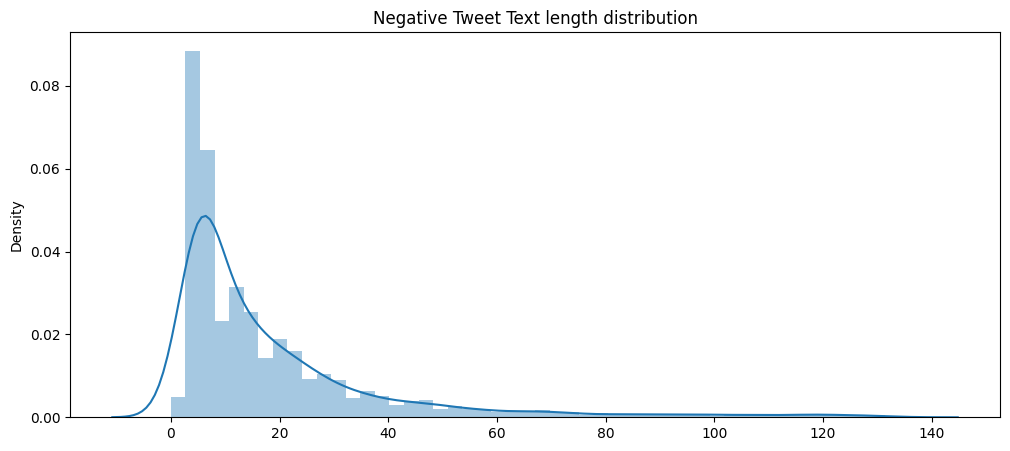

In [71]:
lens = [len(x) for x in neg_df.selected_text]
plt.figure(figsize=(12, 5));
sns.distplot(lens);
plt.title('Negative Tweet Text length distribution')

# Tweet Text length distribution(Neutral)

/var/folders/4y/kdhr0h493ln2xtn2ftcd93km0000gn/T/ipykernel_11023/2591589728.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lens);


Text(0.5, 1.0, 'Neutral Tweet Text length distribution')

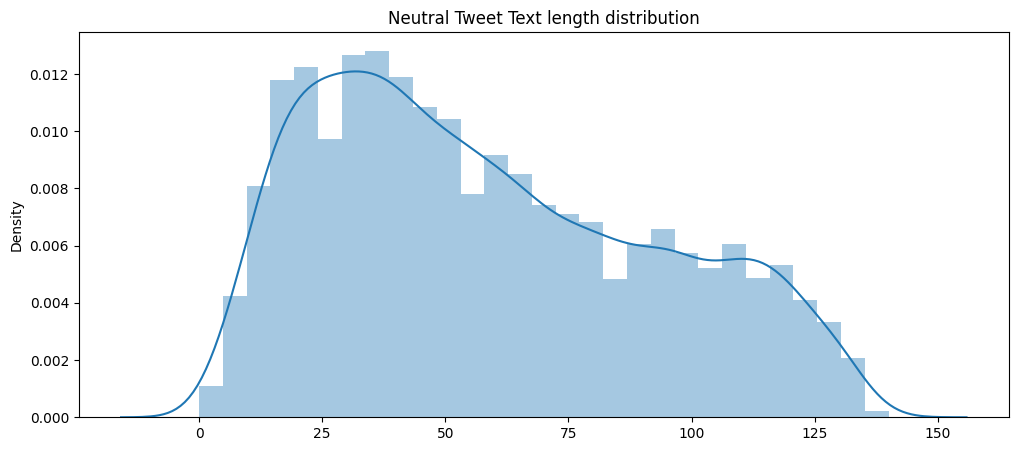

In [16]:
lens = [len(x) for x in neutral_df.selected_text]
plt.figure(figsize=(12, 5));
sns.distplot(lens);
plt.title('Neutral Tweet Text length distribution')

# Pie Chart of Sentiment vs Tweet Count

In [17]:
sent_df_count = pd.DataFrame(list(zip(['positive', 'negative', 'neutral'], [len(df[df['sentiment']=='positive']), len(df[df['sentiment']=='negative']), len(df[df['sentiment']=='neutral'])])), columns = ['Sentiment', 'Count'])

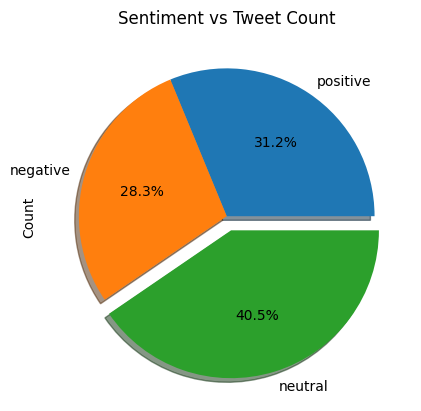

In [18]:
plot = sent_df_count.plot.pie(y='Count', title="Sentiment vs Tweet Count", legend=False, \
                   autopct='%1.1f%%', explode=(0, 0, 0.1), \
                   shadow=True, startangle=0, labels=sent_df_count['Sentiment'])

## Most common words method

In [19]:
def most_common_words_from_data_groups(count_data, count_vectorizer, color='blue'):
   
    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))
    plt.bar(x_pos, counts,align='center', color=color)
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('10 most common words')
    plt.show()

# Most common words for positive sentiment group

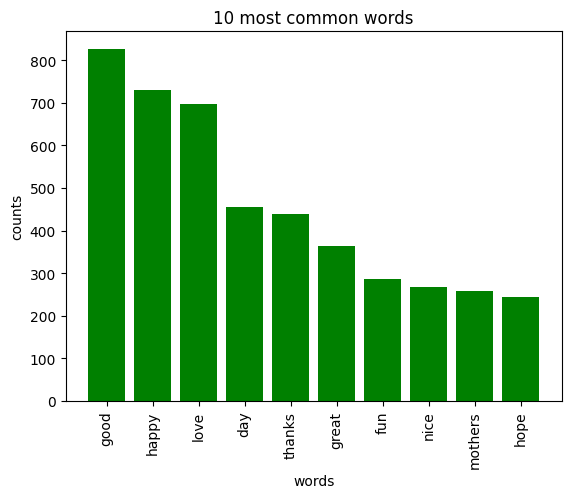

In [20]:
stop_words = stopwords.words('english')
count_vectorizer = CountVectorizer(stop_words=stop_words)
count_data = count_vectorizer.fit_transform(df[df['sentiment'] == 'positive']['selected_text'].values)
most_common_words_from_data_groups(count_data, count_vectorizer, color="green")

# Most common words for negative sentiment group

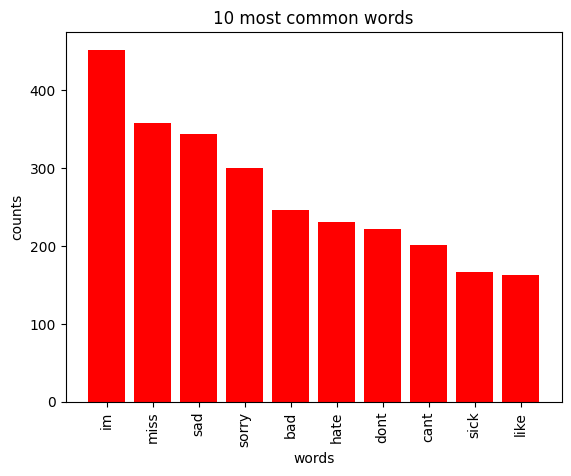

In [21]:
stop_words = stopwords.words('english')

count_vectorizer = CountVectorizer(stop_words=stop_words)
count_data = count_vectorizer.fit_transform(df[df['sentiment'] == 'negative']['selected_text'].values)
most_common_words_from_data_groups(count_data, count_vectorizer, color="red")

# Most common words for neutral sentiment group

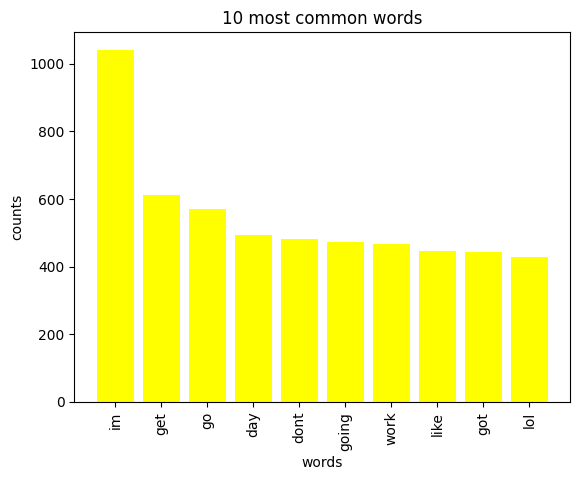

In [22]:
stop_words = stopwords.words('english')

count_vectorizer = CountVectorizer(stop_words=stop_words)
count_data = count_vectorizer.fit_transform(df[df['sentiment'] == 'neutral']['selected_text'].values)
most_common_words_from_data_groups(count_data, count_vectorizer, color="yellow")

# WordCloud generation of positive sentiment group

In [23]:
text = " ".join(tweet for tweet in df[df['sentiment'] == "positive"]['selected_text'])

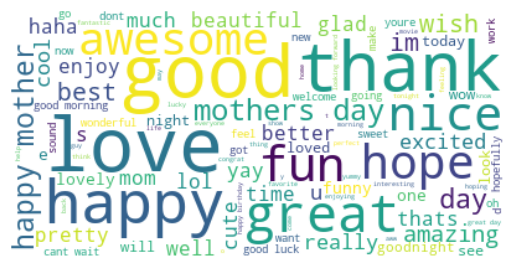

In [24]:
wordcloud = WordCloud(max_font_size=60, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# WordCloud generation of negative sentiment group

In [25]:
text = " ".join(tweet for tweet in df[df['sentiment'] == "negative"]['selected_text'])

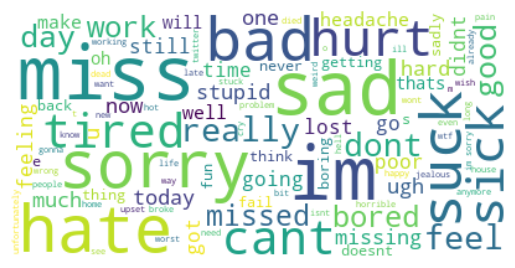

In [26]:
wordcloud = WordCloud(max_font_size=60, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# WordCloud generation of neutral sentiment group

In [27]:
text = " ".join(tweet for tweet in df[df['sentiment'] == "neutral"]['selected_text'])

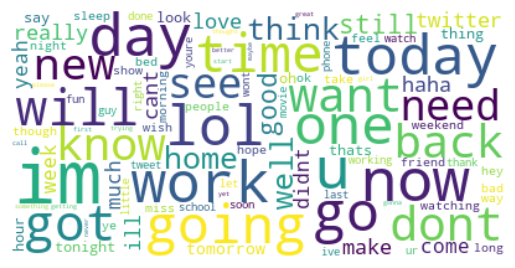

In [28]:
wordcloud = WordCloud(max_font_size=60, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# ML Modeling Data and Splitting

In [29]:
X = df.selected_text
y= df.sentiment

In [30]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,random_state=0,test_size=0.3)

# Logistic Regression Model

In [86]:

#create count vectorizer to transform the training dataset features
vect = CountVectorizer(min_df=5, analyzer='char_wb', ngram_range=(2,5))


#transfomed training and testing dataset
X_train_vectorized = vect.fit_transform(X_train)
X_test_vectorized = vect.transform(X_test)

#build logistic regression model
clf = LogisticRegression(C=0.1,max_iter=500, random_state=0)

#train model
clf.fit(X_train_vectorized,y_train)

#predict  score on testing data
y_pred = clf.predict(X_test_vectorized)
print(clf.score(X_test_vectorized, y_test))

#classification report
report = classification_report(y_test, y_pred, output_dict=True)
lr_rep = pd.DataFrame(report).transpose()
lr_rep.head()
    
    
    


0.829472407519709


,precision,recall,f1-score,support
negative,0.802350,0.814310,0.808286,2348.000000
neutral,0.837423,0.817365,0.827273,3340.000000
positive,0.844350,0.859210,0.851715,2557.000000
accuracy,0.829472,0.829472,0.829472,0.829472
macro avg,0.828041,0.830295,0.829091,8245.000000


## Classification report plot of Logistic Regression Model

In [102]:
#function to plot classification report
def plot_classification_report(rep_df, model_name):
    rep_df = rep_df[0:3]
    ax = rep_df[['precision', 'recall', 'f1-score']].plot(kind='bar', title = model_name + " Performance Metric Graph", figsize=(10,5), legend=True, fontsize=12)
    ax.set_xlabel("Sentiment Classes", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    plt.show()

# Logistic Regression Performance Metric Graph

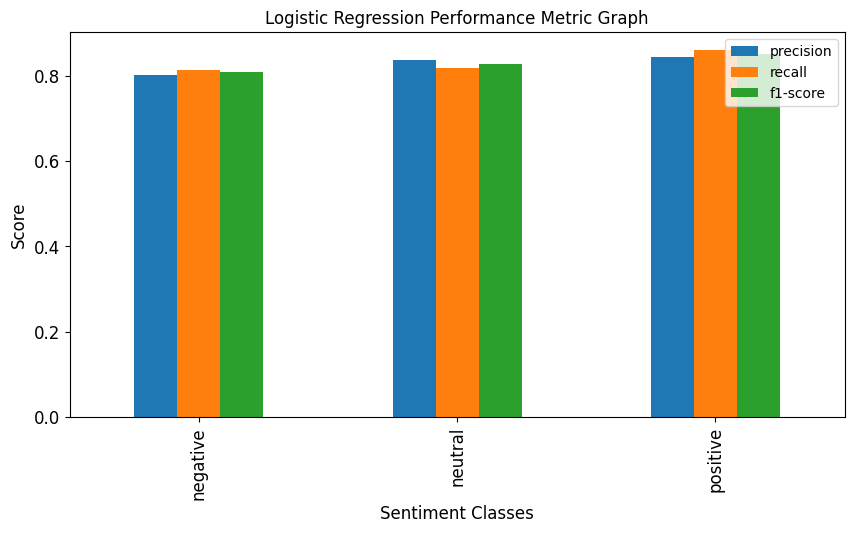

In [103]:
plot_classification_report(lr_rep, "Logistic Regression")

# Random Forest Classifier

In [31]:

#create count vectorizer to transform the training dataset features
vect = CountVectorizer(min_df=5, analyzer='char_wb', ngram_range=(2,5))


#transfomed training and testing dataset
X_train_vectorized = vect.fit_transform(X_train)
X_test_vectorized = vect.transform(X_test)

#build random forest
clf = RandomForestClassifier(random_state=0)

#train model
clf.fit(X_train_vectorized,y_train)

#predict on testing data
y_pred = clf.predict(X_test_vectorized)

print(clf.score(X_test_vectorized, y_test))


#classification report
report = classification_report(y_test, y_pred, output_dict=True)
rf_rep = pd.DataFrame(report).transpose()
rf_rep.head()
    
    
    


0.8276322173702086


,precision,recall,f1-score,support
negative,0.855330,0.729122,0.787199,2311.000000
neutral,0.754708,0.923870,0.830765,3297.000000
positive,0.934763,0.793627,0.858432,2636.000000
accuracy,0.827632,0.827632,0.827632,0.827632
macro avg,0.848267,0.815539,0.825466,8244.000000


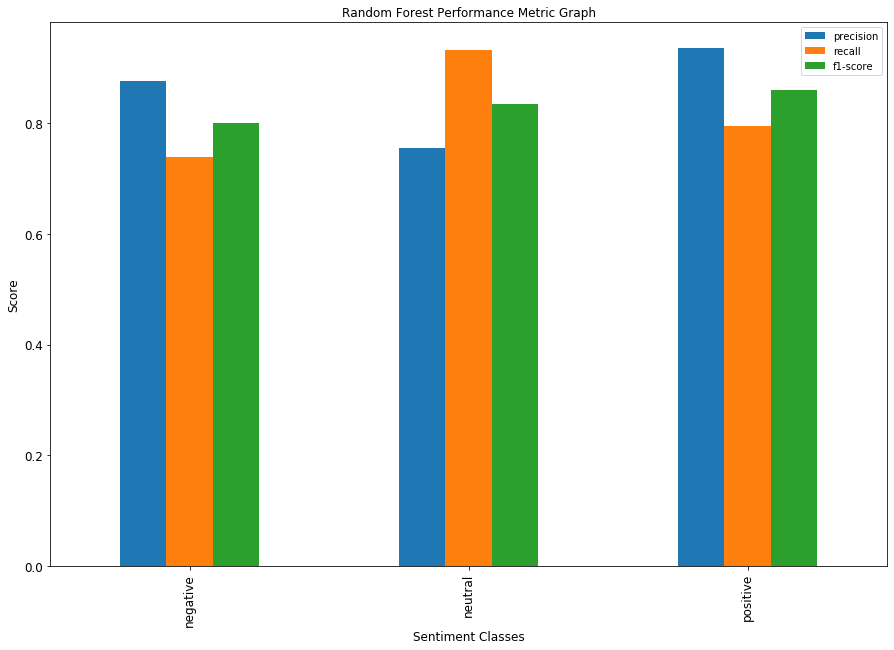

In [34]:
plot_classification_report(rf_rep, "Random Forest")

# MultinomialNB model

In [88]:
#create count vectorizer to transform the training dataset features
vect = CountVectorizer(min_df=5, analyzer='char_wb', ngram_range=(2,5))

#transfomed training and testing dataset
X_train_vectorized = vect.fit_transform(X_train)
X_test_vectorized = vect.transform(X_test)

#create ml MultinomialNB model
clf = MultinomialNB().fit(X_train_vectorized, y_train)

#train model
clf.fit(X_train_vectorized,y_train)

#prediction on testing data
y_pred = clf.predict(X_test_vectorized)

print(clf.score(X_test_vectorized, y_test))


#classfication report
report = classification_report(y_test, y_pred, output_dict=True)
mn_rep = pd.DataFrame(report).transpose()
mn_rep.head()
    

0.8053365676167374


,precision,recall,f1-score,support
negative,0.807026,0.733816,0.768682,2348.000000
neutral,0.769293,0.847605,0.806553,3340.000000
positive,0.858436,0.815800,0.836575,2557.000000
accuracy,0.805337,0.805337,0.805337,0.805337
macro avg,0.811585,0.799074,0.803936,8245.000000


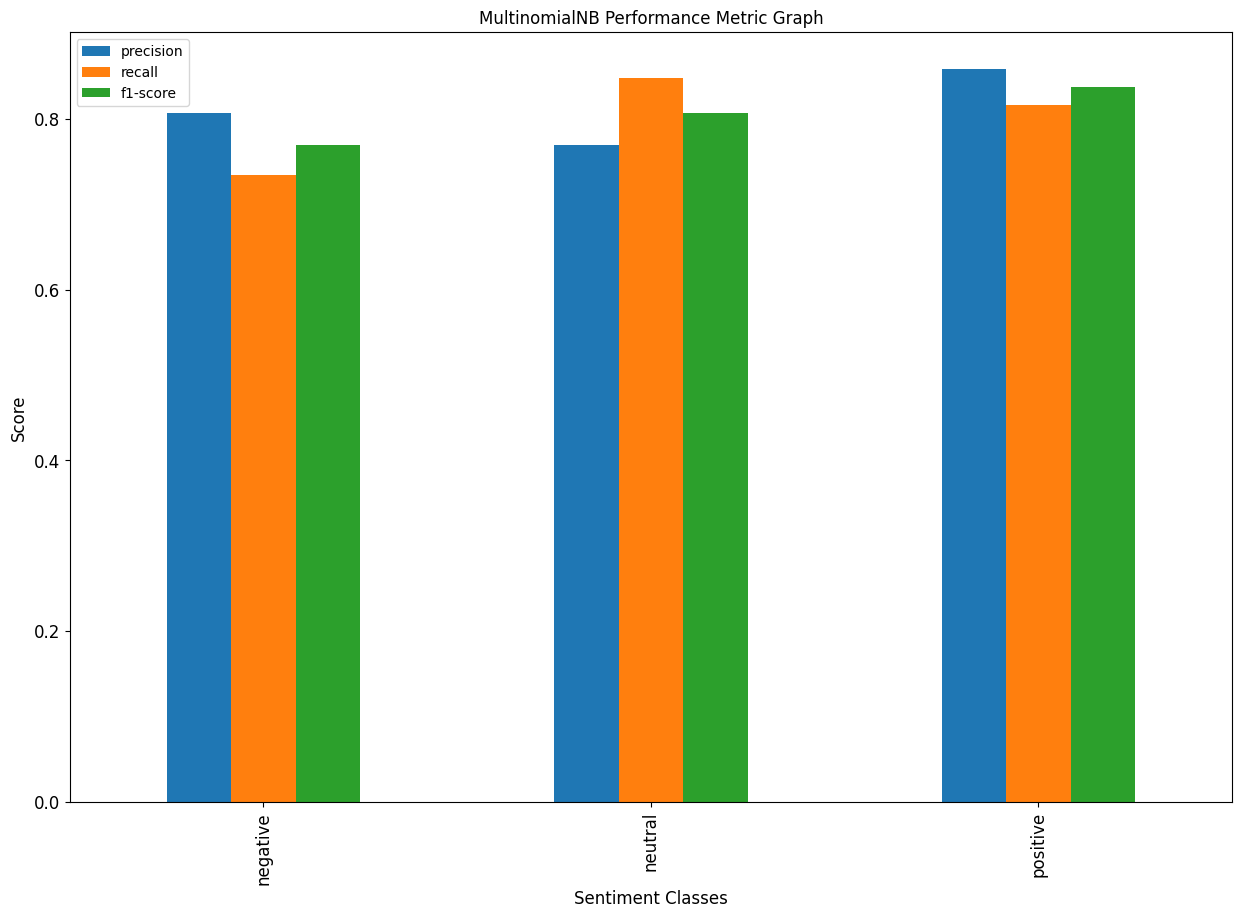

In [49]:
plot_classification_report(mn_rep, "MultinomialNB")

# Xgboost Classifier

In [89]:
from sklearn.preprocessing import LabelEncoder

In [91]:

#create count vectorizer to transform the training dataset features
vect = CountVectorizer(min_df=5, analyzer='char_wb', ngram_range=(2,5))
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
#transfomed training and testing dataset
X_train_vectorized = vect.fit_transform(X_train)
X_test_vectorized = vect.transform(X_test)

#create ml Xgboost model
clf = xgb.XGBClassifier().fit(X_train_vectorized, y_train)

#train model
clf.fit(X_train_vectorized,y_train)

#prediction on test data
y_pred = clf.predict(X_test_vectorized)

print(clf.score(X_test_vectorized, y_test))

#classification report
report = classification_report(y_test, y_pred, output_dict=True)
xgb_rep = pd.DataFrame(report).transpose()
xgb_rep.head()
    



0.8272892662219526


,precision,recall,f1-score,support
0,0.809205,0.771295,0.789795,2348.000000
1,0.801961,0.881437,0.839823,3340.000000
2,0.884418,0.807978,0.844472,2557.000000
accuracy,0.827289,0.827289,0.827289,0.827289
macro avg,0.831861,0.820237,0.824697,8245.000000


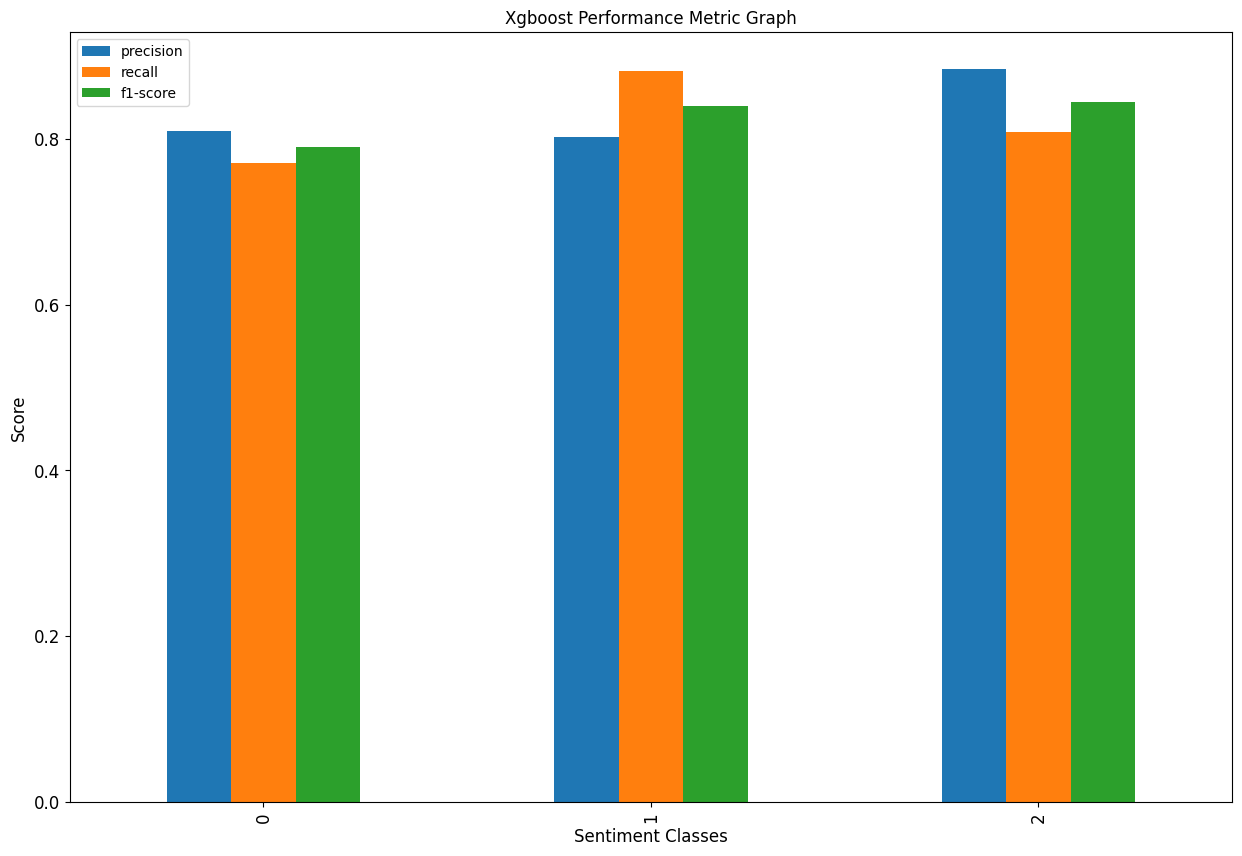

In [57]:
plot_classification_report(xgb_rep, "Xgboost")

## The end 